Mech: ECE, Cathodic: False, Scaling: 0.96, File: ECE_7896.txt
Reversible: True, Merge Potentials: [-324.0, -156.0, 147.0, 430.0]


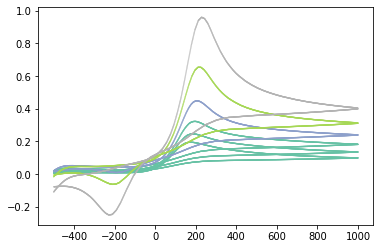

Mech: E, Cathodic: False, Scaling: 0.6, File: E_11148.txt
Reversible: True, Merge Potentials: [-403.0, -168.0, 157.0, 480.0]


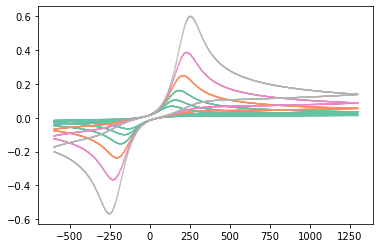

  0%|          | 0/20 [00:00<?, ?it/s]

oopsie


 15%|█▌        | 3/20 [00:08<00:51,  3.04s/it]

oopsie
oopsie
oopsie


 50%|█████     | 10/20 [00:12<00:09,  1.07it/s]

oopsie
oopsie
oopsie


 70%|███████   | 14/20 [00:27<00:14,  2.43s/it]

In [19]:
import pandas as pd, os, numpy as np, random as r, pickle, math
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

class Mech:
   def __init__(self, mech, cathodic):
      self.mech = mech
      self.cathodic = cathodic
      self.data = None
      self.file = None
      self.scaling = r.randint(50, 100)/100

   def __str__(self):
      return f'Mech: {self.mech}, Cathodic: {self.cathodic}, Scaling: {self.scaling}, File: {self.file}'

class MergeCV:
   def __init__(
                  self, 
                  num_to_merge=4,
                  scale_min=0.2, 
                  forward_current_limit=0.05, 
                  reverse_current_limit=0.01,
                  fractional_peak_current=0.33,
                  dictating_scan_rate=-1,
                  peak_ratio=0.1,
                  additional_shift_min=0,
                  additional_shift_max=1000,          
   ):
      self.num_to_merge = num_to_merge
      self.scale_min = scale_min
      self.forward_current_limit = forward_current_limit
      self.reverse_current_limit = reverse_current_limit
      self.fractional_peak_current = fractional_peak_current
      self.dictating_scan_rate = dictating_scan_rate
      self.peak_ratio = peak_ratio
      self.additional_shift_min = additional_shift_min
      self.additional_shift_max = additional_shift_min 
      self.name = ""
      self.mechs = None
      self.res = None

   def __get_mechs(self):
      mechs = [None]*self.num_to_merge
      x = r.randint(1, 8)
      if x == 1:
         cath = round(r.random())
         if cath:
            mechs[0] = Mech("T", True)
         else:
            mechs[-1] = Mech("T", False)

      x = r.randint(1, 8)
      if x == 2:
         cath = round(r.random())
         if cath and not mechs[0]:
            mechs[0] = Mech("ECP", True)
         elif cath:
            mechs[-1] = Mech("ECP", False)
         elif mechs[-1]:
            mechs[0] = Mech("ECP", True)
         else:
            mechs[-1] = Mech("ECP", False)

      # EC1 is equal to EC anodic or CE cathodic, EC2 is equal to CE anodic or EC cathodic
      remaining_mechs = ["E", "EC1", "ECE", "DISP", "CE"] # REMOVED SR
      for i, spot in enumerate(mechs):
         if not spot:
            x = r.randint(0, len(remaining_mechs)-1)
            cathodic = True if round(r.random()) == 1 else False
            mechs[i] = Mech(remaining_mechs[x], cathodic)
      self.mechs = mechs
   
   def __get_valid_file(self, options, mechanism, host_range):
      if host_range == 0:
         return r.choice(options)
      sr_info = pd.read_csv(f'./Scan_Rate_Info/{mechanism}_SRs.csv')
      min_sr_range = host_range-0.2
      max_sr_range = host_range+0.2
      sr_info = sr_info.loc[(sr_info['Range'] >= min_sr_range) & (sr_info['Range'] <= max_sr_range)]
      sr_info = sr_info.loc[sr_info['File'].isin(options)]
      indices = sr_info.index
      return sr_info.loc[r.choice(indices), 'File']  

   def __get_files(self):
      host_range = 0
      for i, mech in enumerate(self.mechs):
         # safe means it can be merged from either side, so no special consideration is necessary
         safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_safe.pkl', 'rb'))
         # half safe means it is useable as a beginning or terminal mechanism so needs to be looked at
         half_safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_half_safe.pkl', 'rb'))
         if i == 1 or i == 2:
            options = list(safe.keys())
            file = self.__get_valid_file(options, mech.mech, host_range)
         # considerations on if T or ECP need to be flipped have already been made so pick any file
         elif mech.mech == 'T' or mech.mech == 'ECP':
            options = list(safe.keys())
            options.extend(list(half_safe.keys()))
            file = self.__get_valid_file(options, mech.mech, host_range)
         else:
            options = list(safe.keys())
            options.extend(list(half_safe.keys()))
            file = self.__get_valid_file(options, mech.mech, host_range)
            if file not in safe:
               # if data is only mergeable from one side, we may need to over-ride the assigned flipping
               left_safe = half_safe[file][0]
               right_safe = half_safe[file][1]
               if left_safe: # must be flipped if it is left most, otherwise can't be
                  if i == 0:
                     mech.cathodic = True
                  else:
                     mech.cathodic = False
               else: # must be flipped if it right most, otherwise can't be
                  if i == 0:
                     mech.cathodic = False
                  else:
                     mech.cathodic = True
         mech.file = file
         self.name += file[:-4] + "_"
         mech.data = pd.read_csv(f'./Samples/{mech.mech}/{file}')
         if host_range == 0:
            host_range = math.log10(max(mech.data['v'])) - math.log10(min(mech.data['v']))
         min_V = min(mech.data['V'])
         mech.data.loc[:,'V'] -= min_V
         mech.data.reset_index(inplace=True, drop=True)

   def __adjust_data(self, mech):
      flip = -1 if mech.cathodic else 1
      mech.data.loc[:, 'A'] *= mech.scaling*flip
      res = pd.DataFrame()
      if mech.cathodic:
         for v in mech.data['v'].unique():
            t = mech.data.loc[mech.data['v'] == v].copy()
            currents = t.loc[:,'A']
            n = len(currents)//2
            fwd_currents = list(currents[:n])
            rev_currents = list(currents[n:])
            rev_currents.extend(fwd_currents)
            t['A'] = rev_currents
            res = pd.concat([res, t])
         mech.data = res
      mech.data.reset_index(inplace=True, drop=True)   

   def __get_reversibility(self, mech):
      lcl_data = mech.data.loc[mech.data['v'] == max(mech.data['v'])].copy()
      min_cur = min(lcl_data['A'])
      max_cur = max(lcl_data['A'])
      peak_ratio = abs(min_cur/max_cur) if abs(min_cur) < max_cur else abs(max_cur/min_cur)
      return peak_ratio >= 0.1
    
   def __calculate_merge_reps(self, mech):

      def find_index(l, r, target, data):
         decreasing = data.loc[l, 'A'] > data.loc[r, 'A']
         while (l <= r):
            m = l+(r-l) // 2
            if data.loc[m, 'A'] < target:
               if decreasing:
                  r = m-1
               else:
                  l = m+1
            else:
               if decreasing:
                  l = m+1
               else:
                  r = m-1
         return l if l <= data.index[-1] else data.index[-1]

      scan_rates = mech.data['v'].unique()
      rep_data = mech.data[mech.data['v'] == scan_rates[self.dictating_scan_rate]]

      max_A = max(rep_data['A'])
      min_A = min(rep_data['A'])
      
      reversible = self.__get_reversibility(mech)
      main_peak = max_A if max_A > abs(min_A) else min_A
      # Mpi = max peak index, mpi = min peak index
      Mpi = rep_data[rep_data['A'] == max_A].index[0]
      mpi = rep_data[rep_data['A'] == min_A].index[0]

      merge_points = []
      indices = rep_data.index
      l = indices[0]
      r = indices[-1]
      n = indices[len(indices)//2]
      if rep_data.loc[Mpi, 'A'] == main_peak or reversible:
         target = self.fractional_peak_current*(max_A-rep_data.loc[n,'A']) + rep_data.loc[n,'A']
         merge_points.append(find_index(l, Mpi, target, rep_data))
         merge_points.append(find_index(Mpi, n, target, rep_data))
      if rep_data.loc[mpi, 'A'] == main_peak or reversible:
         target = rep_data.loc[r,'A'] - self.fractional_peak_current*(abs(min_A-rep_data.loc[r,'A']))
         merge_points.append(find_index(n+1,mpi, target, rep_data))
         merge_points.append(find_index(mpi, r, target, rep_data))
   
      mech.data['merge_point'] = False
      for point in merge_points:
         mech.data.loc[point, 'merge_point'] = True

   def initialize_data(self):
      mechs = self.__get_mechs()
      self.__get_files()
      for i, mech in enumerate(self.mechs):
         self.__adjust_data(mech)
         self.__calculate_merge_reps(mech)

   def __calculate_shifts(self):

      def get_mps(indices, data):
         max_potential = data.loc[indices[0], 'V']
         min_potential = max_potential
         for i in range(1, len(indices)):
            cur = data.loc[indices[i], 'V']
            max_potential = max(max_potential, cur)
            min_potential = min(min_potential, cur)
         return [min_potential, max_potential]

      host = self.mechs[0].data
      mpis = host.loc[host['merge_point']].index
      host_mps = get_mps(mpis, host)
      shifts = [0]
      for i in range(1, len(self.mechs)):
         guest = self.mechs[i].data
         mpis = guest.loc[guest['merge_point']].index
         guest_mps = get_mps(mpis, guest)
         host_pot = host_mps[1]
         guest_pot = guest_mps[0]
         shift = (host_pot-guest_pot) + r.randint(self.additional_shift_min, self.additional_shift_max)
         shifts.append(shift)
         guest_mps[1] += shift
         host_mps = guest_mps
      return shifts

   def format_data(self):
      shifts = self.__calculate_shifts()
      for i, mech in enumerate(self.mechs):
         mech.data.loc[:,'V'] += shifts[i]
         mapping = {v:i for i,v in enumerate(mech.data['v'].unique())}
         mech.data.replace({'v': mapping}, inplace=True)
         mech.data.drop(['merge_point'], axis=1, inplace=True)

   def __merge_dfs(self, dfs, rev=False):
      res = pd.DataFrame()
      left_adds = []
      right_adds = []
      for df in dfs:
         if rev:
            df = df[::-1]
         left_adds.append([min(df['V']), df.loc[df.index[0], 'A']])
         right_adds.append([max(df['V']), df.loc[df.index[-1], 'A']])   
         if len(res) == 0:
            res = df
         else:
            res = pd.concat([res, df]).groupby(['V','v']).sum().reset_index()
      res.drop(['index'], axis=1, inplace=True)
      for left in left_adds:
         res.loc[res['V'] < left[0], 'A'] += left[1]
      for right in right_adds:
         res.loc[res['V'] > right[0], 'A'] += right[1]
      return res

   def merge(self, single=False):
      res = pd.DataFrame()
      for i in range(6):
         fwd_dfs = []
         rev_dfs = []
         name = ""
         global_max = 0
         for j, mech in enumerate(self.mechs):
            if j == 3:
               global_max = max(mech.data['V'])
            name += mech.file[:-4]
            data = mech.data[mech.data['v'] == i].copy()
            data.reset_index(inplace=True)
            n = data.loc[data['V'] == max(data['V'])].index[0]
            fwd_dfs.append(data.iloc[:n, :])
            rev_dfs.append(data.iloc[n:, :])
         fwd_full = self.__merge_dfs(fwd_dfs)
         rev_full = self.__merge_dfs(rev_dfs, rev=True)
         rev_full = rev_full[::-1]
         res = pd.concat([res, fwd_full, rev_full])
         if single:
            res = res.loc[(res['V'] > 0) & (res['V'] < global_max)]
            res.reset_index(inplace=True, drop=True)
            self.res = res
            return res # tabbed in for single scan rate
      res = res.loc[(res['V'] > 0) & (res['V'] < global_max)]
      res.reset_index(inplace=True, drop=True)
      self.res = res
      return res

   def simple_plot(self):
      for mech in self.mechs:
         data = mech.data
         plt.scatter(data['V'], data['A'], s=0.1, c=data['v'], cmap='Set2')
         plt.show()
         plt.clf()

   def fancy_plot(self, save=False, highlight=False):
      fig = plt.figure(constrained_layout=True)
      gs = GridSpec(4,2, figure=fig,hspace=0, wspace=0)
      cmap='viridis'
      components = []
      components.append(fig.add_subplot(gs[3:4, :1]))
      components.append(fig.add_subplot(gs[2:3, :1]))
      components.append(fig.add_subplot(gs[3:4, -1:]))
      components.append(fig.add_subplot(gs[2:3, -1:]))

      ax1 = fig.add_subplot(gs[:2,:])
      infos = [["Mech"],["Scaling"],["Direction"]]
      name = ""
      if highlight:
         colors=['rebeccapurple', 'dodgerblue', 'cyan', 'black']
      else:
         colors=['white']*self.num_to_merge
      bar_xs = []
      bar_widths = []
      for i, mech in enumerate(self.mechs):
         name += mech.file[:-4] + "_"
         infos[0].append(mech.mech)
         infos[1].append(mech.scaling)
         infos[2].append("cathodic" if mech.cathodic else "anodic")
         ax = components.pop(0)
         ax.get_xaxis().set_ticks([])
         ax.get_yaxis().set_ticks([])
         ax.patch.set_facecolor(colors[i])
         ax.patch.set_alpha(0.2)
         ax.scatter(mech.data['V'], mech.data['A'], s=0.02, c=mech.data['v'], cmap=cmap)
         min_V = max(0, min(mech.data['V']))
         max_V = min(max(self.res['V']), max(mech.data['V']))
         bar_width = max_V-min_V
         bar_xs.append(min_V + bar_width//2)
         bar_widths.append(max_V-min_V)

      bottom = min(self.res['A'])
      y_range =max(self.res['A']) - min(self.res['A'])
      bar_heights = [y_range/4]*self.num_to_merge
      bottoms = [bottom + i*bar_heights[0] for i in range(4)]
      bar_heights = [y_range/4]*self.num_to_merge
      ax1.bar(bar_xs, bar_heights, bottom=bottoms, width=bar_widths, color=colors, alpha=0.2, zorder=0)
      ax1.scatter(self.res['V'], self.res['A'], s=0.05, c=self.res['v'], cmap=cmap, zorder=1)
      ax1.table(infos, loc='top', cellLoc='center')
      ax1.tick_params(axis="both", labelsize=8)
      if save:
         plt.savefig(f'./Graphs/{name}image', dpi=200)
      else:
         plt.show()
      plt.clf()

   def save(self):
      info = {}
      for i, mech in enumerate(self.mechs):
         info['Cathodic'] = mech.cathodic
         info['Scaling'] = mech.scaling
         info['File'] = mech.file
         info['Position'] = i
      pickle.dump(info, open(f'./Generated_Data/{self.name}details', 'wb'))
      pickle.dump(self.res, open(f'./Generated_Data/{self.name}data', 'wb'))

   def get_report(self, file):
      mech = file[:file.find('_')]
      mech_obj = Mech(mech, False)
      mech_obj.file = file
      mech_obj.data = pd.read_csv(f'./Samples/{mech}/{file}')
      mech_obj.data.loc[:, 'A'] *= mech_obj.scaling
      self.mechs = [mech_obj]
      self.__calculate_merge_reps(mech_obj)
      reversible = self.__get_reversibility(mech_obj)
      merge_points = mech_obj.data.loc[mech_obj.data['merge_point']].index
      pots = sorted([mech_obj.data.loc[i, 'V'] for i in merge_points])
      print(mech_obj)
      print(f'Reversible: {reversible}, Merge Potentials: {pots}')
      self.simple_plot()

merger = MergeCV()
merger.get_report('ECE_7896.txt')
merger.get_report('E_11148.txt')

for i in tqdm(range(20)): # ~ 100/minute w/ graphing every 25, ≥ 140k per day)
   try:
      merger = MergeCV()
      merger.initialize_data()
      merger.format_data()
      merger.merge()
      if i % 1 == 0:
         merger.fancy_plot(save=True, highlight=True)
   except:
      print("oopsie")
   #merger.save()

In [ ]:
mechs = ['ECE','E','T','EC1','DISP','EC1','CE']
path = './Samples'
for mech in mechs:
   files = os.listdir(f'{path}/{mech}')
   files = [f for f in files if f.endswith('txt')] 
   info = []
   for file in files:
      data = pd.read_csv(f'{path}/{mech}/{file}')
      range_srs = math.log10(max(data['v'])) - math.log10(min(data['v']))
      info.append([file, range_srs])
   sr_data = pd.DataFrame(info, columns=['File', 'Range'])
   sr_data.to_csv(f'./SR_Info/{mech}_SRs.csv', index=False)
sr_data